In [1]:
!pip3 uninstall -y kaggle
!pip3 install --upgrade pip
!pip3 install kaggle==1.5.6
!kaggle -v

Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (19.3.1)
     |████████████████████████████████| 61kB 2.3MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=068ec6e6fb4bce9979520c12869a5b0d5c59faf81a7203f5f8bc604f54306601
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 149, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [2]:
!mkdir /root/.kaggle
## Upload the kaggle.json file.
!cp kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!kaggle competitions download -c plant-seedlings-classification
!unzip plant-seedlings-classification.zip
!rm plant-seedlings-classification.zip sample_submission.csv

 99% 1.67G/1.69G [00:15<00:00, 129MB/s]
100% 1.69G/1.69G [00:15<00:00, 114MB/s]
Archive:  plant-seedlings-classification.zip
  inflating: sample_submission.csv   
  inflating: test/0021e90e4.png      
  inflating: test/003d61042.png      
  inflating: test/007b3da8b.png      
  inflating: test/0086a6340.png      
  inflating: test/00c47e980.png      
  inflating: test/00d090cde.png      
  inflating: test/00ef713a8.png      
  inflating: test/01291174f.png      
  inflating: test/026716f9b.png      
  inflating: test/02cfeb38d.png      
  inflating: test/03566743d.png      
  inflating: test/03a2ee656.png      
  inflating: test/03e322a29.png      
  inflating: test/03ef36742.png      
  inflating: test/043449b0b.png      
  inflating: test/0437393b1.png      
  inflating: test/04814f36d.png      
  inflating: test/05341a8a6.png      
  inflating: test/060450d79.png      
  inflating: test/060f1dc84.png      
  inflating: test/0625f063b.png      
  inflating: test/063363305.png      
 

In [4]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

from tensorflow.keras.utils import to_categorical
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, MaxPooling2D, Lambda
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import keras.backend as K
import tensorflow as tf

import random
import matplotlib.pyplot as plt
import sys
import numpy as np

import os
import cv2
import math
import itertools
import pandas as pd
import random
from scipy import ndarray

# image processing library
import skimage as sk
from skimage import transform
from skimage import util
from skimage import io

from glob import glob
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.backend import set_session,tensorflow_backend

config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
config.gpu_options.per_process_gpu_memory_fraction = 0.5
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

Using TensorFlow backend.


## Constants

In [0]:
TRAIN_DIRECTORY = "train"
TEST_DIRECTORY = "test"
IMG_HEIGHT = 68
IMG_WIDTH = 68
CATEGORIES = os.listdir(TRAIN_DIRECTORY)
num_classes = len(CATEGORIES)

FILTER = False

## Equalise the image count

In [0]:
def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

In [0]:
def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array)

In [0]:
def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]

In [0]:
def generate_files(num_files_desired, folder_path):
    num_generated_files = 0
    # find all files paths from the folder
    images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    
    while num_generated_files <= num_files_desired:
        # random image from the folder
        image_path = random.choice(images)
        # read image as an two dimensional array of pixels
        image_to_transform = sk.io.imread(image_path)
        # random num of transformation to apply
        num_transformations_to_apply = random.randint(1, len(available_transformations))

        num_transformations = 0
        transformed_image = None
        while num_transformations <= num_transformations_to_apply:
            # random transformation to apply for a single image
            key = random.choice(list(available_transformations))
            transformed_image = available_transformations[key](image_to_transform)
            num_transformations += 1

        new_file_path = '%s/augmented_image_%s.png' % (folder_path, num_generated_files)

        # write image to the disk
        io.imsave(new_file_path, transformed_image)
        num_generated_files += 1

In [10]:
#get list of folders in the train directory and count contents
files_count = pd.DataFrame(columns=['Label','Count'])
for name in os.listdir(TRAIN_DIRECTORY):
    files_count = files_count.append({'Label': TRAIN_DIRECTORY + '/' + name, 'Count': len(os.listdir(TRAIN_DIRECTORY + '/' + name))}, ignore_index=True)
    print(name)

Common wheat
Sugar beet
Small-flowered Cranesbill
Black-grass
Scentless Mayweed
Charlock
Shepherds Purse
Cleavers
Loose Silky-bent
Common Chickweed
Fat Hen
Maize


In [11]:
files_count

,Label,Count
0,train/Common wheat,221
1,train/Sugar beet,385
2,train/Small-flowered Cranesbill,496
3,train/Black-grass,263
4,train/Scentless Mayweed,516
5,train/Charlock,390
6,train/Shepherds Purse,231
7,train/Cleavers,287
8,train/Loose Silky-bent,654
9,train/Common Chickweed,611


In [12]:
# dictionary of the transformations we defined earlier
available_transformations = {
    'rotate': random_rotation,
    'noise': random_noise,
    'horizontal_flip': horizontal_flip
}

for i in range(len(files_count)):
    label = files_count.iloc[i]
    folder_path = label['Label']
    num_files_desired = 500 - label['Count']
    print(num_files_desired)
    
    if num_files_desired > 0:
        generate_files(num_files_desired, folder_path)

    # find all files paths from the folder
    images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    print(len(images))

279


501
115


501
4


501
237


501
-16
516
110


501
269


501
213


501
-154
654
-111
611
25


501
279


501


## Load and prepare data

In [13]:
path_to_all_files = TRAIN_DIRECTORY + '/*/*.png' 
files = glob(path_to_all_files)

trainImg = []
trainLabel = []
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    trainImg.append(cv2.resize(cv2.imread(img), (IMG_WIDTH, IMG_HEIGHT)))  # Get image (with resizing)
    trainLabel.append(img.split('/')[-2])  # Get image label (folder name)

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set

print(trainImg.shape)
print(trainLabel.shape)

(6290, 68, 68, 3)
(6290, 1)


In [14]:
path_to_all_files = TEST_DIRECTORY + '/*.png' 
files = glob(path_to_all_files)

testImg = []
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    testImg.append(cv2.resize(cv2.imread(img), (IMG_WIDTH, IMG_HEIGHT)))  # Get image (with resizing)

testImg = np.asarray(testImg)  # Train images set

print(testImg.shape)


(794, 68, 68, 3)


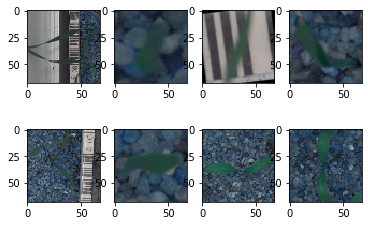

In [15]:
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(trainImg[i*100])

## Cleaning data

### Remove background

In [0]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [0]:
clearTrainImg = []
for img in trainImg:
    image = sharpen_image(segment_plant(img))
    clearTrainImg.append(image)
    
clearTrainImg = np.asarray(clearTrainImg)

In [0]:
clearTestImg = []
for img in testImg:
    image = sharpen_image(segment_plant(img))
    clearTestImg.append(image)
    
clearTestImg = np.asarray(clearTestImg)

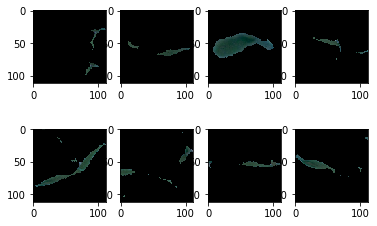

In [0]:
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(clearTrainImg[i*10])

## Normalise and change labels to categorical

In [0]:
#Use filtered data or not
if FILTER == False:
    trainImg = trainImg / 255
    testImg = testImg / 255
else:
    trainImg = clearTrainImg / 255
    testImg = clearTestImg / 255

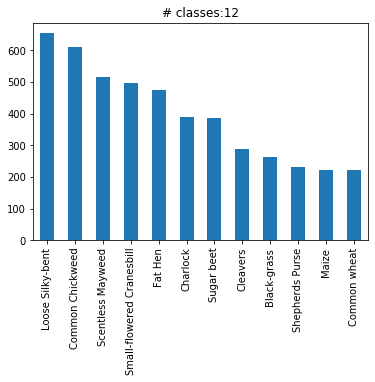

In [0]:
le = preprocessing.LabelEncoder()
encodeTrainLabels = le.fit_transform(trainLabel[0])
clearTrainLabel = to_categorical(encodeTrainLabels)

# Plot of label types numbers
trainLabel[0].value_counts().plot(kind='bar', title="# classes:" + str(clearTrainLabel.shape[1]))

### Train and validation, image generator

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(trainImg, clearTrainLabel, 
                                                test_size=0.2, random_state=33, 
                                                stratify = clearTrainLabel)

In [0]:
BATCH_SIZE = 16
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=180,  # randomly rotate images in the range
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1,  # randomly shift images vertically 
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=True)  # randomly flip images vertically

train_datagen.fit(X_train)

## Convolutional Auto Encoder Model

In [0]:
input_img = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)) 

x = Conv2D(filters=128, kernel_size=(5, 5), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=32, kernel_size=(5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=16, kernel_size=(5, 5), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
encoded = Flatten()(encoded)

x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (5, 5), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

encoder = Model(input_img, encoded)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 112, 112, 3)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 112, 112, 128)     9728      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 56, 56, 128)       512       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 56, 56, 64)        204864    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 32)        5123

In [0]:
autoencoder_train = autoencoder.fit_generator(
    train_datagen.flow(X_train, X_train, batch_size=BATCH_SIZE), 
                           epochs=20,
                           validation_data=(X_valid, X_valid), 
                           steps_per_epoch=(10 * X_train.shape[0]) / BATCH_SIZE)

Epoch 1/20
2375/2375 [==============================] - 166s 70ms/step - loss: 0.1773 - acc: 0.8044 - val_loss: 0.6515 - val_acc: 0.8060
Epoch 2/20
2375/2375 [==============================] - 166s 70ms/step - loss: 0.1736 - acc: 0.8048 - val_loss: 0.4993 - val_acc: 0.8060
Epoch 3/20
2375/2375 [==============================] - 165s 69ms/step - loss: 0.1727 - acc: 0.8048 - val_loss: 0.4127 - val_acc: 0.8059
Epoch 4/20
2375/2375 [==============================] - 164s 69ms/step - loss: 0.1726 - acc: 0.8046 - val_loss: 0.4651 - val_acc: 0.7862
Epoch 5/20
2375/2375 [==============================] - 163s 69ms/step - loss: 0.1720 - acc: 0.8047 - val_loss: 0.5900 - val_acc: 0.7160
Epoch 6/20
2375/2375 [==============================] - 163s 69ms/step - loss: 0.1718 - acc: 0.8049 - val_loss: 1.7803 - val_acc: 0.6187
Epoch 7/20
2375/2375 [==============================] - 162s 68ms/step - loss: 0.1717 - acc: 0.8046 - val_loss: 0.9342 - val_acc: 0.6860
Epoch 8/20
2375/2375 [===================

In [0]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
train_results = encoder.predict(trainImg)

In [0]:
test_results = encoder.predict(testImg)

In [0]:
test_results.shape

(794, 784)

In [0]:
np.savetxt('test.csv', test_results, delimiter=',')